In [10]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
import matplotlib.pyplot as plt

from datasets import DataCifar10

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# DTYPE = torch.FloatTensor # run on CPU
DTYPE = torch.cuda.FloatTensor # run on GPU

NOISE_DIM = 128

# Dataset

In [24]:
# MNIST dataset
dataloader = DataCifar10('./datasets/cifar-10-batches-py/', norm_type='max_min_-1_1')
dataloader.show_info()

Training data shape:  (50000, 3, 32, 32)
Training labels shape:  (50000,)
Validating data shape:  (0, 3, 32, 32)
Validating labels shape:  (0,)
Testing data shape:  (10000, 3, 32, 32)
Testing labels shape:  (10000,)


In [13]:
# only keep one type
idx = dataloader.y_train == 0
# dataloader.x_train = dataloader.x_train[idx]
# dataloader.y_train = dataloader.y_train[idx]

idx = dataloader.y_test == 0
# dataloader.x_test = dataloader.x_test[idx]
# dataloader.y_test = dataloader.y_test[idx]

# show info
# dataloader.show_info()

Training data shape:  (5000, 3, 32, 32)
Training labels shape:  (5000,)
Validating data shape:  (0, 3, 32, 32)
Validating labels shape:  (0,)
Testing data shape:  (1000, 3, 32, 32)
Testing labels shape:  (1000,)


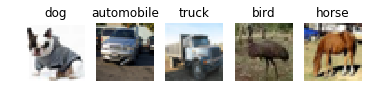

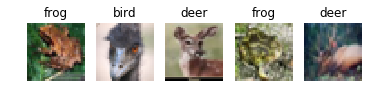

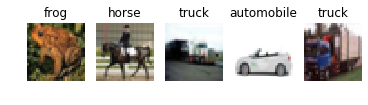

In [25]:
# show some data
x, y = dataloader.get_batch(15)
dataloader.show_by_data(x, y)

# Deeply Convolutional GANs

In [26]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)
    
class Unflatten(nn.Module):
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)
    
# sample noise
def sample_noise(batch_size, dim=NOISE_DIM, dtype=DTYPE):
    noise = torch.rand([batch_size, dim]) * 2 - 1
    return noise.type(dtype)

# train GAN
def train_gan(D, G, D_Loss, G_Loss, D_optimer, G_optimer, dataloader, 
              num_ite=4000, dtype=DTYPE):
    # hyperparameters
    batch_size = 128
    
    # prepare
    D = D.type(dtype)
    G = G.type(dtype)
    
    # train
    for t in range(num_ite):
        # train the discriminator
        D_optimer.zero_grad()
        
        data_real, _ = dataloader.get_batch_torch(batch_size, dtype=dtype)
        scores_real = D(data_real)# .type(dtype)
        
        noise = sample_noise(batch_size, dtype=dtype)
        data_fake = G(noise).detach().view(-1, 3, 32, 32)
        scores_fake = D(data_fake)# .type(dtype)
        
        d_loss = D_Loss(scores_real, scores_fake)
        d_loss.backward()
        
        D_optimer.step()
        
        # train the generator
        for _ in range(3):
            G_optimer.zero_grad()

            noise = sample_noise(batch_size, dtype=dtype)
            data_fake = G(noise).view(-1, 3, 32, 32)
            scores_fake = D(data_fake)# .type(dtype)

            g_loss = G_Loss(scores_fake)
            g_loss.backward()

            G_optimer.step()
        
        # show training info
        if t == 0 or (t + 1) % 200 == 0:
            print('After {} iteration: D loss {:.5}, G loss {:.5}'.format(t + 1, d_loss.item(), g_loss.item()))
            
        if t == 0 or (t + 1) % 1000 == 0:
            images = data_fake.data.cpu().numpy()
            dataloader.show_by_data(images[0: 10], None, maxflen=5)
    
    # return
    return G

def dc_discriminator():
    model = nn.Sequential(
        Unflatten(-1, 3, 32, 32),
        nn.Conv2d(3, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(5 * 5 * 64, 5 * 5 * 64),
        nn.LeakyReLU(0.01),
        nn.Linear(5 * 5 * 64, 1)
    )
    return model

def dc_generator(noise_dim=NOISE_DIM):
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 8 * 8 * 128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(8 * 8 * 128),
        Unflatten(-1, 128, 8, 8),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
        nn.Tanh(),
        Flatten()
    )
    return model

def bce_loss(scores, target):
    neg_abs = - scores.abs()
    loss = scores.clamp(min=0) - scores * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(scores_real, scores_fake):
    N_real = scores_real.shape[0]
    N_fake = scores_fake.shape[0]
    return bce_loss(scores_real, 1) + bce_loss(scores_fake, 0)

def generator_loss(scores_fake):
    N_fake = scores_fake.shape[0]
    return bce_loss(scores_fake, 1)

After 1 iteration: D loss 1.3704, G loss 2.3922


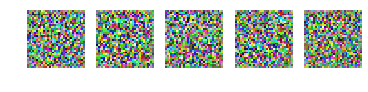

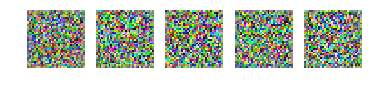

After 200 iteration: D loss 1.3787, G loss 0.70815
After 400 iteration: D loss 1.3818, G loss 0.71781
After 600 iteration: D loss 1.3848, G loss 0.70431
After 800 iteration: D loss 1.3873, G loss 0.68528
After 1000 iteration: D loss 1.3874, G loss 0.69228


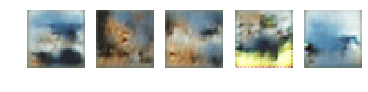

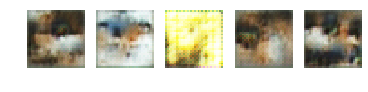

After 1200 iteration: D loss 1.392, G loss 0.69138
After 1400 iteration: D loss 1.3867, G loss 0.69977
After 1600 iteration: D loss 1.3919, G loss 0.70701
After 1800 iteration: D loss 1.3812, G loss 0.69246
After 2000 iteration: D loss 1.392, G loss 0.69839


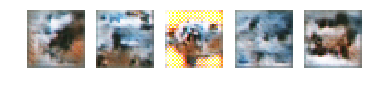

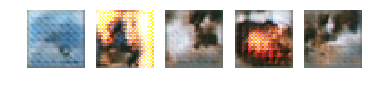

After 2200 iteration: D loss 1.3855, G loss 0.69449
After 2400 iteration: D loss 1.3881, G loss 0.70629
After 2600 iteration: D loss 1.3844, G loss 0.70572
After 2800 iteration: D loss 1.3843, G loss 0.69528
After 3000 iteration: D loss 1.3835, G loss 0.69146


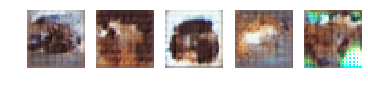

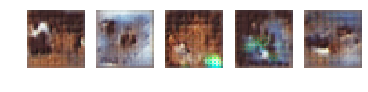

After 3200 iteration: D loss 1.3747, G loss 0.66212
After 3400 iteration: D loss 1.3826, G loss 0.68407
After 3600 iteration: D loss 1.3881, G loss 0.69216
After 3800 iteration: D loss 1.3891, G loss 0.67596
After 4000 iteration: D loss 1.3977, G loss 0.69406


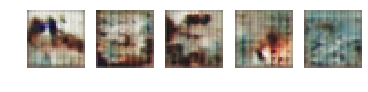

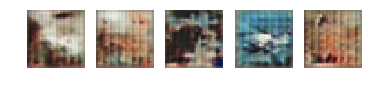

After 4200 iteration: D loss 1.3828, G loss 0.70085
After 4400 iteration: D loss 1.3772, G loss 0.71003
After 4600 iteration: D loss 1.3694, G loss 0.62419
After 4800 iteration: D loss 1.5251, G loss 0.73508
After 5000 iteration: D loss 1.4054, G loss 0.69849


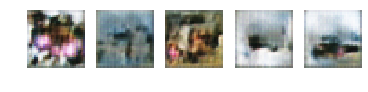

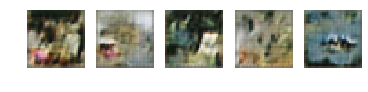

After 5200 iteration: D loss 1.3972, G loss 0.70555
After 5400 iteration: D loss 1.3594, G loss 0.70444
After 5600 iteration: D loss 1.3855, G loss 0.73022
After 5800 iteration: D loss 1.398, G loss 0.68939
After 6000 iteration: D loss 1.436, G loss 0.77952


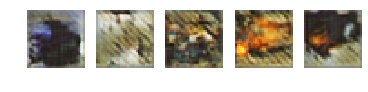

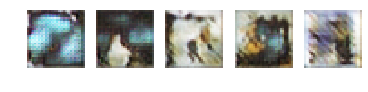

After 6200 iteration: D loss 1.4269, G loss 0.66531
After 6400 iteration: D loss 1.3638, G loss 0.6641
After 6600 iteration: D loss 1.373, G loss 0.66131
After 6800 iteration: D loss 1.3885, G loss 0.70203
After 7000 iteration: D loss 1.426, G loss 0.68951


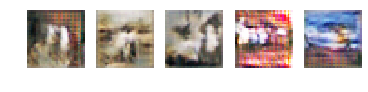

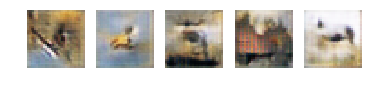

After 7200 iteration: D loss 1.3243, G loss 0.67927
After 7400 iteration: D loss 1.322, G loss 0.79255
After 7600 iteration: D loss 1.3595, G loss 0.93799
After 7800 iteration: D loss 1.23, G loss 0.99026
After 8000 iteration: D loss 1.2133, G loss 0.88594


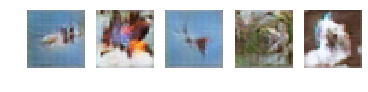

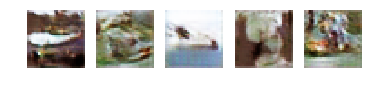

After 8200 iteration: D loss 1.1655, G loss 0.98876
After 8400 iteration: D loss 1.0789, G loss 1.0644
After 8600 iteration: D loss 1.1298, G loss 1.3072
After 8800 iteration: D loss 0.93395, G loss 1.3641
After 9000 iteration: D loss 0.97077, G loss 1.1439


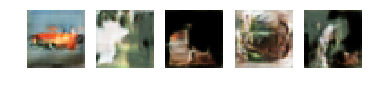

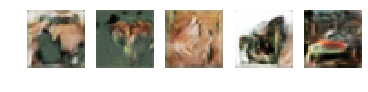

After 9200 iteration: D loss 0.92184, G loss 1.2816
After 9400 iteration: D loss 0.70081, G loss 1.6139
After 9600 iteration: D loss 0.67537, G loss 1.5485
After 9800 iteration: D loss 0.59051, G loss 1.8395
After 10000 iteration: D loss 0.67373, G loss 2.0069


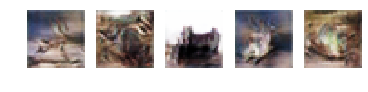

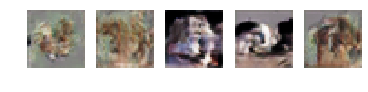

After 10200 iteration: D loss 0.65749, G loss 2.2229
After 10400 iteration: D loss 0.69035, G loss 2.0137
After 10600 iteration: D loss 0.39602, G loss 2.6017
After 10800 iteration: D loss 0.54342, G loss 2.5858
After 11000 iteration: D loss 0.42636, G loss 2.9681


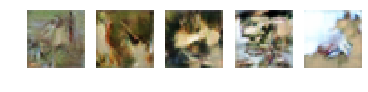

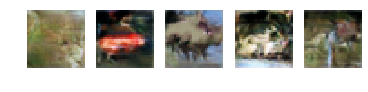

After 11200 iteration: D loss 0.40843, G loss 3.0433
After 11400 iteration: D loss 0.34361, G loss 3.4307
After 11600 iteration: D loss 0.37018, G loss 3.252
After 11800 iteration: D loss 0.25869, G loss 3.4267
After 12000 iteration: D loss 0.39628, G loss 3.4197


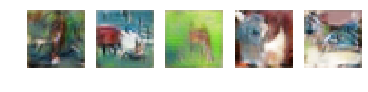

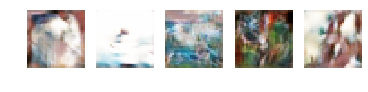

After 12200 iteration: D loss 0.40991, G loss 3.9304
After 12400 iteration: D loss 0.26321, G loss 3.4242
After 12600 iteration: D loss 0.30466, G loss 4.8503
After 12800 iteration: D loss 0.22786, G loss 3.9118
After 13000 iteration: D loss 0.32581, G loss 5.0679


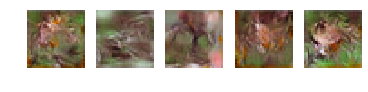

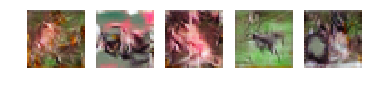

After 13200 iteration: D loss 0.19303, G loss 4.3797
After 13400 iteration: D loss 0.17033, G loss 5.3864
After 13600 iteration: D loss 0.12371, G loss 5.8996
After 13800 iteration: D loss 0.12274, G loss 4.9297
After 14000 iteration: D loss 0.18429, G loss 5.9514


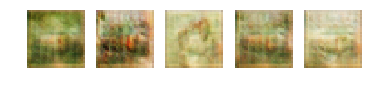

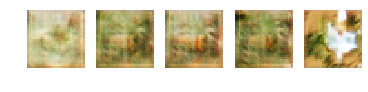

After 14200 iteration: D loss 0.14711, G loss 4.3774
After 14400 iteration: D loss 0.6479, G loss 2.3176
After 14600 iteration: D loss 0.81196, G loss 2.126
After 14800 iteration: D loss 0.63308, G loss 3.2787
After 15000 iteration: D loss 0.54423, G loss 3.2848


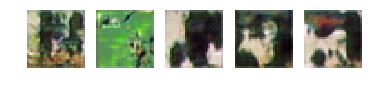

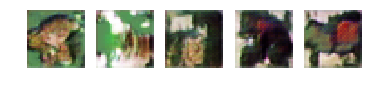

After 15200 iteration: D loss 0.1701, G loss 3.8607
After 15400 iteration: D loss 0.38118, G loss 3.5705
After 15600 iteration: D loss 0.20104, G loss 4.0239
After 15800 iteration: D loss 0.12003, G loss 4.8842
After 16000 iteration: D loss 0.25309, G loss 5.4273


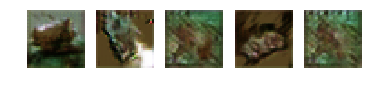

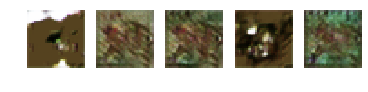

After 16200 iteration: D loss 0.098092, G loss 4.9313
After 16400 iteration: D loss 0.24041, G loss 4.0585
After 16600 iteration: D loss 0.23828, G loss 3.7879
After 16800 iteration: D loss 0.23208, G loss 5.4694
After 17000 iteration: D loss 0.24668, G loss 5.0899


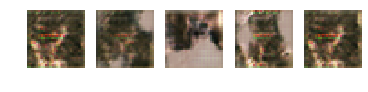

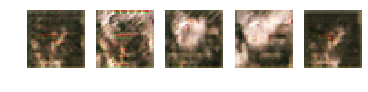

After 17200 iteration: D loss 0.23362, G loss 4.2366
After 17400 iteration: D loss 0.25257, G loss 5.6993
After 17600 iteration: D loss 0.61054, G loss 6.4998
After 17800 iteration: D loss 0.14705, G loss 4.9668
After 18000 iteration: D loss 0.11103, G loss 3.7668


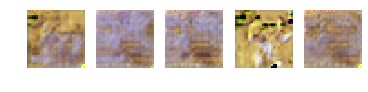

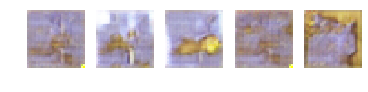

After 18200 iteration: D loss 0.91544, G loss 2.7428
After 18400 iteration: D loss 0.34858, G loss 3.7008
After 18600 iteration: D loss 0.43982, G loss 4.4127
After 18800 iteration: D loss 0.39664, G loss 3.9573
After 19000 iteration: D loss 0.19574, G loss 3.7789


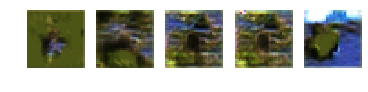

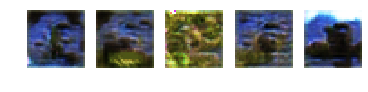

After 19200 iteration: D loss 0.25593, G loss 3.7377
After 19400 iteration: D loss 0.26944, G loss 5.6747
After 19600 iteration: D loss 0.31612, G loss 5.746
After 19800 iteration: D loss 0.42082, G loss 3.9438
After 20000 iteration: D loss 0.11725, G loss 4.2644


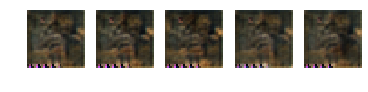

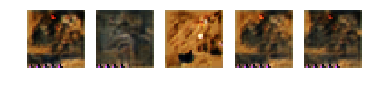

In [27]:
# the models
D_dc = dc_discriminator()
G_dc = dc_generator()

# the optimers
D_dc_optimer = optim.Adam(D_dc.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_dc_optimer = optim.Adam(G_dc.parameters(), lr=1e-3, betas=(0.5, 0.999))

# train
G_LS_trained = train_gan(D_dc, G_dc, discriminator_loss, generator_loss, 
                         D_dc_optimer, G_dc_optimer, dataloader, num_ite=20000)